In [ ]:
!pip install descartes

In [ ]:
!pip install osmnx

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 102.4/102.4 kB 2.6 MB/s eta 0:00:00


In [ ]:
import geopandas as gpd
import matplotlib.pyplot as plt
import networkx as nx
import osmnx as ox
from descartes import PolygonPatch
from shapely.geometry import Point, LineString, Polygon
ox.config(log_console=True, use_cache=True)
ox.__version__

<ipython-input-3-fe4a2da7e8f6>:7: UserWarning: The `utils.config` function is deprecated and will be removed in a future release. Instead, use the `settings` module directly to configure a global setting's value. For example, `ox.settings.log_console=True`.
  ox.config(log_console=True, use_cache=True)


'1.7.1'

In [ ]:
# настроить место, тип сети, время поездки и скорость движения
place = 'Moscow, Russia'
network_type = 'drive'
trip_times = [5, 10, 15, 20] #в минутах
travel_speed = 20 #скорость в км/час

## Загрузите и подготовьте уличную сеть

In [ ]:
# загрузить уличную сеть
G = ox.graph_from_place(place, network_type=network_type)

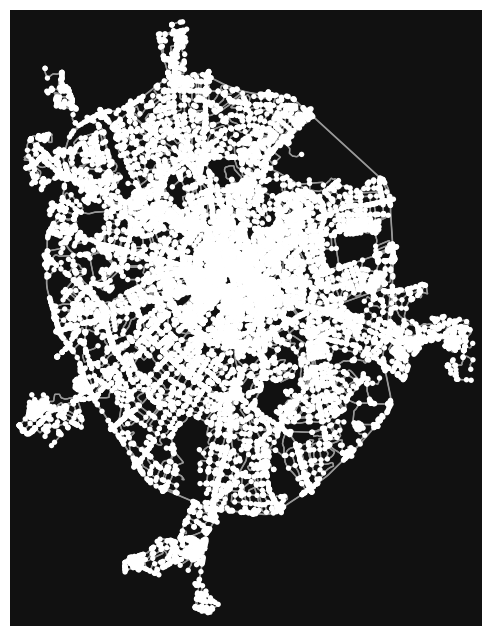

(<Figure size 800x800 with 1 Axes>, <Axes: >)

In [ ]:
ox.plot.plot_graph(G)

In [ ]:
point = 55.741735,37.546930

In [ ]:
# найдите самый центральный узел
gdf_nodes = ox.graph_to_gdfs(G, edges=False)
x, y = gdf_nodes['geometry'].unary_union.centroid.xy
center_node = ox.nearest_nodes(G, point[1], point[0])
G = ox.project_graph(G)

In [ ]:
# добавьте атрибут ребра для времени в минутах, необходимого для прохождения каждого ребра
meters_per_minute = travel_speed * 1000 / 60 #км в час → м в минуту
for u, v, k, data in G.edges(data=True, keys=True):
    data['time'] = data['length'] / meters_per_minute

## Каждый раз отображает узлы, до которых можно добраться на машине.

Как далеко вы сможете уехать за 5, 10, 15, 20 и 25 минут от исходного узла?
Мы будем использовать NetworkX, чтобы создать подграф G на каждом расстоянии на основе времени поездки и скорости движения.

In [ ]:
# получить один цвет для каждой изохроны
iso_colors = ox.plot.get_colors(n=len(trip_times), cmap='plasma', start=0, return_hex=True)

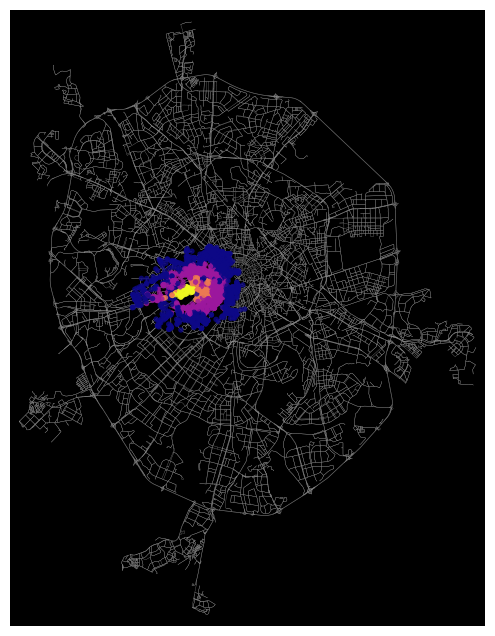

In [ ]:
# раскраска узлов в соответствии с изохроной, затем постройте уличную сеть
node_colors = {}
for trip_time, color in zip(sorted(trip_times, reverse=True), iso_colors):
    subgraph = nx.ego_graph(G, center_node, radius=trip_time, distance='time')
    for node in subgraph.nodes():
        node_colors[node] = color
nc = [node_colors[node] if node in node_colors else 'none' for node in G.nodes()]
ns = [15 if node in node_colors else 0 for node in G.nodes()]
fig, ax = ox.plot_graph(G, node_color=nc, node_size=ns, node_alpha=0.8, node_zorder=2,
                        bgcolor='k', edge_linewidth=0.2, edge_color='#999999')

In [ ]:
# создаём изохронные полигоны
isochrone_polys = []
for trip_time in sorted(trip_times, reverse=True):
    subgraph = nx.ego_graph(G, center_node, radius=trip_time, distance='time')
    node_points = [Point((data['lat'], data['lon'])) for node, data in subgraph.nodes(data=True)]
    bounding_poly = gpd.GeoSeries(node_points).unary_union.convex_hull
    isochrone_polys.append(bounding_poly)

In [ ]:
isochrone_polys

[<POLYGON ((55.73 37.482, 55.716 37.519, 55.714 37.533, 55.714 37.533, 55.714...>,
 <POLYGON ((55.734 37.502, 55.726 37.534, 55.726 37.561, 55.727 37.582, 55.73...>,
 <POLYGON ((55.738 37.525, 55.737 37.572, 55.738 37.587, 55.744 37.588, 55.74...>,
 <POLYGON ((55.74 37.536, 55.738 37.538, 55.739 37.548, 55.743 37.563, 55.745...>]

In [ ]:
print(subgraph.nodes(data=True))

[(334452352, {'y': 6178515.393069025, 'x': 409497.8604409819, 'street_count': 1, 'lon': 37.5583603, 'lat': 55.7438757}), (253317121, {'y': 6178714.332721426, 'x': 409926.6349165903, 'street_count': 3, 'lon': 37.5651224, 'lat': 55.7457426}), (305778818, {'y': 6178350.545619984, 'x': 408862.2964154565, 'street_count': 3, 'lon': 37.5482948, 'lat': 55.7422758}), (302942339, {'y': 6178881.914139358, 'x': 409300.2601842409, 'street_count': 3, 'lon': 37.5550921, 'lat': 55.747131}), (6594764036, {'y': 6178295.251862822, 'x': 409355.6679135548, 'street_count': 2, 'lon': 37.5561691, 'lat': 55.7418717}), (10860687241, {'y': 6178464.116890481, 'x': 409832.9191157693, 'street_count': 3, 'lon': 37.5637126, 'lat': 55.7434776}), (334454922, {'y': 6178229.777528177, 'x': 409193.9971921227, 'street_count': 3, 'lon': 37.5536166, 'lat': 55.7412533}), (334454034, {'y': 6178291.481526964, 'x': 408775.91059359093, 'street_count': 4, 'lon': 37.546939, 'lat': 55.741729}), (5691571357, {'y': 6178380.485769976, 

In [ ]:
import folium

# Создание карты
m = folium.Map(location=point, zoom_start=100)

folium.Marker(location=point, popup='Center', icon=folium.Icon(color='red')).add_to(m)

# Пройтись по списку полигонов
for i, polygon in enumerate(isochrone_polys):

    # Получить координаты полигона
    coordinates = list(polygon.exterior.coords)

    # Создать FeatureGroup для каждого полигона
    fg = folium.FeatureGroup(name=f"Polygon {i+1}")

    # Добавить полигон в FeatureGroup
    folium.PolyLine(locations=coordinates, color='black', fill_color=iso_colors[i], fill_opacity=0.5).add_to(fg)

    # Добавить FeatureGroup на карту
    fg.add_to(m)

# Добавить слой для управления FeatureGroup
folium.LayerControl().add_to(m)

# Отобразить карту
m
